# A cursory attempt to compare Logistic Regression vs Neural Network #

Below we will compare the train, validation and test errors using logistic regression vs neural network. As we will see, logistic regression produces an unbiased AUC estimate of ~75% while the neural network comes in around 80%. The NN has significantly lower cost, but only slightly improved accuracy. Overfitting?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn import metrics
import os
import random

np.random.seed(1)

# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.

# Exploratory Data Analysis #

Let's first take a look at the data and normalize it as needed.

We can also add new features to the existing dataset. Notice that 1s only occur ~10% of the time. Anomaly detection with an appropriate distribution may be worth a try.

In [2]:
train = pd.read_csv('../input/train.csv')

In [3]:
print(f"Train shape:{train.shape}")

train.describe()

Train shape:(200000, 202)


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [4]:
train = train.drop(columns=['ID_code'])

In [5]:
#add new feature: squared-values
for col in train.columns:
    if col != 'target':
        train[col + '_sq'] = train[col]**2 

In [6]:
def normalize_inputs(inputs, everything=False):
    if everything:
        X = inputs
    else:
        X = inputs[:, 1:]
        
    mu = np.mean(X, axis=0).reshape(1,X.shape[1])
    sigma = np.std(X, axis=0).reshape(1,X.shape[1])
    
    X = (X-mu)/sigma
    
    if everything:
        return X
    else:
        return np.concatenate((inputs[:, 0].reshape(inputs.shape[0],1), X), axis=1)

def split_dataset(dataset, pct_train=0.6, pct_dev=0.2, pct_test=0.2):
    (m, n) = dataset.shape
    np.random.shuffle(dataset)
    
    if (pct_train + pct_dev + pct_test) != 1.0:
        pass #need to sum to 1
    elif pct_train <= 0.0:
        pass # cannot have 0% percent to train
    elif pct_dev <= 0.0 or pct_test <= 0.0:       #if pct_test or pct_dev is 0, call the other dataset "test" and return both train & test
        train = dataset[:int(m*pct_train+1),:]    #if both pct_test and pct_dev is 0, return the empty dataset "test"
        test = dataset[int(m*pct_train+1):,:]

        X_train = train[:, 1:]
        Y_train = train[:, 0].reshape(train.shape[0], 1)

        X_test = test[:, 1:]
        Y_test = test[:, 0].reshape(test.shape[0], 1)
    
        return X_train, Y_train, X_test, Y_test
    else:                                         #if neither pct_test nor pct_dev is 0, return 3 datasets
        train = dataset[:int(m*pct_train+1),:]
        dev = dataset[int(m*pct_train+1):int(m*(pct_train+pct_dev)+1),:]
        test = dataset[int(m*(pct_train+pct_dev)+1):,:]
        
        X_train = train[:, 1:]
        Y_train = train[:, 0].reshape(train.shape[0], 1)
        
        X_dev = dev[:, 1:]
        Y_dev = dev[:, 0].reshape(dev.shape[0], 1)
        
        X_test = test[:, 1:]
        Y_test = test[:, 0].reshape(test.shape[0], 1)
        
        return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [7]:
train = train.values
train = normalize_inputs(train)
(X_train, Y_train, X_dev, Y_dev, X_test, Y_test) = split_dataset(train, pct_train=0.7, pct_dev=0.15, pct_test=0.15)
(X_train, Y_train, X_dev, Y_dev, X_test, Y_test) = (X_train.T, Y_train.T, X_dev.T, Y_dev.T, X_test.T, Y_test.T) #X is (n,m) matrix; Y is (1,m) matrix

# Logistic Regression #

Let's first try to run a simple logistic regression to see how a simple model performs

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def lr_cost(theta, X,  Y):
    (n,m) = X_train.shape
    h = sigmoid(np.dot(theta.T, X)) #h is (1,m) vector
    cost = -1/m * (np.dot(Y, np.log(h).T) + np.dot((1-Y), np.log(1-h).T)) #scalar
    grad = 1/m * np.dot(X_train, (h - Y_train).T)
    
    return cost, grad

def lr_predict(theta, X):
    p = sigmoid(np.dot(theta.T, X))
    
    return np.round(p)
    
def lr_model(X_train, Y_train, X_test, Y_test, learning_rate=1, num_iter=20):
    (n,m) = X_train.shape
    theta = np.zeros((n,1)) # theta is (n,1) matrix
    costs = []   

    for i in range(num_iter): # gradient descent
        cost, grad = lr_cost(theta, X_train, Y_train)
        theta = theta - learning_rate * grad
        costs.append(cost)
        if i % 10 == 0:
            print(f"Cost after {i} iterations: {np.squeeze(cost)}")

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    prediction = lr_predict(theta, X_train)
    accuracy = metrics.roc_auc_score(Y_train.T, prediction.T)
    print(f"Train accuracy: {accuracy}")

    prediction = lr_predict(theta, X_test)
    accuracy = metrics.roc_auc_score(Y_test.T, prediction.T)
    print(f"Test accuracy: {accuracy}")
    
    return theta

Cost after 0 iterations: 0.6931471805599148
Cost after 10 iterations: 0.6563656367473952


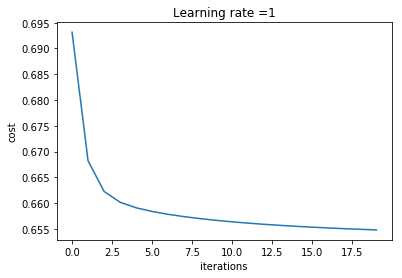

Train accuracy: 0.7466435761874712
Test accuracy: 0.7437329502348631
Unbiased AUC estimate for LR: 0.746892976734


In [9]:
weights = lr_model(X_train, Y_train, X_dev, Y_dev)
predictions = lr_predict(weights, X_test)
unbiased_auc = metrics.roc_auc_score(Y_test.T, predictions.T)
print(f"Unbiased AUC estimate for LR: {unbiased_auc}")

# Neural Network #

Let's try a 4-layer neural network with ReLU hidden activations and final Sigmoid activation.

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed=1):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # randomly mix (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # partition (shuffled_X, shuffled_Y), minus the end case
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def create_placeholders(n):
    X = tf.placeholder(tf.float32, shape=[n, None], name='X')
    Y = tf.placeholder(tf.float32, shape=[1, None], name='Y')
    
    return X, Y

def initialize_parameters(n):    
    tf.set_random_seed(1)
    
    l1 = 256                     # Hyperparameter: no of hidden units for each layer
    l2 = 128
    l3 = 64
    
    W1 = tf.get_variable("W1", [l1,n], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [l1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [l2,l1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [l2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [l3,l2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [l3,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable("W4", [1,l3], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable("b4", [1,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}
    
    return parameters

def forward_propagation(X, parameters, dropout_rate=0):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    A1_dropout = tf.nn.dropout(A1, keep_prob=(1-dropout_rate))      # inverted dropout
    
    Z2 = tf.add(tf.matmul(W2, A1_dropout), b2)
    A2 = tf.nn.relu(Z2)
    A2_dropout = tf.nn.dropout(A2, keep_prob=(1-dropout_rate))
    
    Z3 = tf.add(tf.matmul(W3, A2_dropout), b3)
    A3 = tf.nn.relu(Z3)
    A3_dropout = tf.nn.dropout(A3, keep_prob=(1-dropout_rate))
    
    Z4 = tf.add(tf.matmul(W4, A3_dropout), b4)
        
    return Z4

def compute_cost(Z4, Y, parameters, lambd=0.01):
    logits = tf.transpose(Z4) # inputs of tf.nn.sigmoid_cross_entropy need to be shape (m, 1)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    reg_cost = tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + tf.nn.l2_loss(parameters['W3']) + tf.nn.l2_loss(parameters['W4'])
    cost = tf.reduce_mean(cost + lambd * reg_cost)
    
    return cost
    
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01, lambd = 0.01, dropout_rate = 0, num_epochs = 10, minibatch_size = 32, to_print = True):
    tf.set_random_seed(1)
    seed = 3
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n, m) = X_train.shape
    costs = []
    train_aucs = []
    test_aucs = []
    
    X,Y = create_placeholders(n)
    parameters = initialize_parameters(n)
    Z4 = forward_propagation(X, parameters, dropout_rate)
    cost = compute_cost(Z4, Y, parameters, lambd)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    # Compute AUC for evaluation
    prediction = tf.cast(tf.nn.sigmoid(Z4) > 0.5, "float") # Prediction decision boundary value
    auc = tf.metrics.auc(Y, prediction)[1]

    with tf.Session() as sess:
        sess.run(init)       

        for epoch in range(num_epochs):

            epoch_cost = 0.
            seed += 1
            num_minibatches = int(m / minibatch_size) 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            costs.append(epoch_cost) #track costs for each epoch
            sess.run(tf.local_variables_initializer()) #need local variables for auc
            train_aucs.append(sess.run(auc, feed_dict={X: X_train, Y: Y_train}))
            test_aucs.append(sess.run(auc, feed_dict={X: X_test, Y: Y_test}))
                
            if to_print == True and epoch % 10 == 0:
                print (f"Cost after epoch {epoch}: {epoch_cost}")
                
        # at this point, model is done training; run variables to return
        sess.run(tf.local_variables_initializer()) #need local variables for auc        
        parameters = sess.run(parameters)
        train_auc = sess.run(auc, feed_dict={X: X_train, Y: Y_train})
        test_auc = sess.run(auc, feed_dict={X: X_test, Y: Y_test})
        aucs = (train_auc, test_auc)
        
        if to_print == True:
            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
        
            print ("Parameters have been trained!")
        
            # plot the accuracy
            plt.plot(train_aucs, linestyle='dashed') #train accuracy is dashed
            plt.plot(test_aucs)
            plt.xlabel('iterations')
            plt.title('Train (dashed) vs. Test AUC')
            plt.show()       
        
            print(f"Train AUC: {train_auc}")
            print(f"Test AUC: {test_auc}")
                
        return parameters, aucs
    
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4}
    
    n = X.shape[0]
    x = tf.placeholder(tf.float32, shape=[n, None], name='X')
    
    z4 = forward_propagation(x, params)
    p = tf.nn.sigmoid(z4)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

Cost after epoch 0: 0.25907963042616927
Cost after epoch 10: 0.08016363949210725


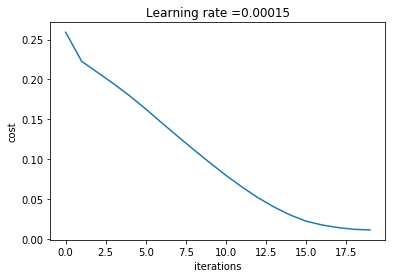

Parameters have been trained!


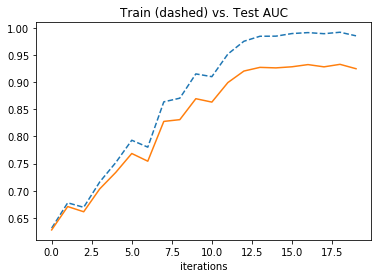

Train AUC: 0.9854636788368225
Test AUC: 0.9248476624488831
Unbiased AUC estimate for NN: 0.7883935213722447


In [11]:
parameters, auc = model(X_train, Y_train, X_dev, Y_dev, learning_rate=0.00015, lambd=0, dropout_rate=0, num_epochs=20, minibatch_size=128)
# compute AUC for test dataset
predictions = predict(X_test, parameters)
unbiased_auc = metrics.roc_auc_score(Y_test.T, predictions.T)
print(f"Unbiased AUC estimate for NN: {unbiased_auc}")